In [1]:
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2022_01/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0-ext/eups 	setup
lsst_distrib          g7ae64ea4b3+830bbabcd1 	current w_latest w_2022_01 setup


In [2]:
import os
import sys
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from lsst.obs.lsst import LsstCam
from lsst.afw.cameraGeom.utils import findAmp
from lsst.geom import Point2I
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
import logging
from lsst.utils.timer import time_this
sys.path.append('/sdf/home/a/abrought/bin')
from SpotAnalysis import Analyzer
import gc; gc.collect()

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

repo = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml"

butler = Butler(repo)
registry = butler.registry

In [3]:
cols = ["u/abrought/BF/run_13240/R24_S11/uncorrected"]
cols2 = ["u/abrought/BF/run_13239/R24_S11/uncorrected"]
subbutler = Butler(repo, collections=cols)
subbutler2 = Butler(repo, collections=cols2)
subregistry = subbutler.registry
subregistry2 = subbutler2.registry

datasetRefs = list(subregistry.queryDatasets(datasetType="gridSpotSrc"))
datasetRefs2 = list(subregistry2.queryDatasets(datasetType="gridSpotSrc"))
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)



table = []
for i, aref in enumerate(datasetRefs):
    raw = subbutler.get("raw",dataId=aref.dataId)
    md = raw.getMetadata()
    sensor = md["RAFTBAY"] + "_" + md["CCDSLOT"]
    seqnum = md["SEQNUM"]
    tseqnum = md["TSEQNUM"]
    exptime = md["EXPTIME"]
    time = md["MJD"]
    botx,boty = md["BOTX"], md["BOTY"]
    del raw

    # Get camera/sensor information
    camera = LsstCam().getCamera()
    detector = camera.get(sensor)

    # Get the peak spot values, channel, and amplifier names
    postisr = subbutler.get("postISRCCD",dataId=aref.dataId)
    m = postisr.getMetadata()
    image = postisr.getImage().getArray()
    del postisr

    src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
    mdsrc = src.getMetadata()
    x0 = mdsrc['GRID_X0']
    y0 = mdsrc['GRID_Y0']
    grid_theta = mdsrc['GRID_THETA']
    
    maxradius = 15.*np.mean([mdsrc["GRID_XSTEP"], mdsrc["GRID_YSTEP"]])
    minradius = 10. *np.mean([mdsrc["GRID_XSTEP"], mdsrc["GRID_YSTEP"]])
    distances = np.sqrt((src["spotgrid_x"] - x0)**2 + (src["spotgrid_y"] - y0)**2)
    ind = (distances >= minradius) & (distances <= maxradius)
    
    #ind = np.argwhere(src["spotgrid_index"] == 1200)

    if len(src['spotgrid_index'][ind]) == 0:
        print("Could not find any spots:", "Skipping " + str(i) + "/" + str(len(datasetRefs)))
        continue
    
    x_all = src['base_SdssCentroid_y'][ind]
    y_all = src['base_SdssCentroid_x'][ind]
    del src
    
    signals = []
    distmatrix = []
    for x_iter,y_iter in zip(x_all, y_all):
        x = int(x_iter) # The coordinate systems are flipped
        y = int(y_iter)

        xmin = max(0,x-33)
        xmax = min(image.shape[0]-1, x+33)
        ymin = max(0,y-33)
        ymax = min(image.shape[1]-1, y+33)

        xs, ys = np.meshgrid(np.arange(xmin,xmax), np.arange(ymin,ymax))
        radii = np.sqrt((xs - x)**2 + (ys - y)**2)
        del xs
        del ys

        signals.append(np.ravel(image[xmin:xmax,ymin:ymax]))
        distmatrix.append(np.ravel(radii))

    table.append(
        {
            "exptime": exptime,
            "SEQNUM": seqnum,
            "TSEQNUM": tseqnum,
            "MJD": time,
            "BOTX": botx,
            "BOTY": boty,
            "signals": np.ravel(np.asarray(signals)),
            "radii": np.ravel(distmatrix)
        }
    )
    print(i, sys.getsizeof(table),"bytes")
    gc.collect()
    


for i, aref in enumerate(datasetRefs2):
    raw = subbutler2.get("raw",dataId=aref.dataId)
    md = raw.getMetadata()
    sensor = md["RAFTBAY"] + "_" + md["CCDSLOT"]
    seqnum = md["SEQNUM"]
    tseqnum = md["TSEQNUM"]
    exptime = md["EXPTIME"]
    time = md["MJD"]
    botx,boty = md["BOTX"], md["BOTY"]
    del raw

    # Get camera/sensor information
    camera = LsstCam().getCamera()
    detector = camera.get(sensor)

    # Get the peak spot values, channel, and amplifier names
    postisr = subbutler2.get("postISRCCD",dataId=aref.dataId)
    m = postisr.getMetadata()
    image = postisr.getImage().getArray()
    del postisr

    src = subbutler2.get("gridSpotSrc",dataId=aref.dataId)
    mdsrc = src.getMetadata()
    x0 = mdsrc['GRID_X0']
    y0 = mdsrc['GRID_Y0']
    grid_theta = mdsrc['GRID_THETA']
    
    maxradius = 15.*np.mean([mdsrc["GRID_XSTEP"], mdsrc["GRID_YSTEP"]])
    minradius = 10. *np.mean([mdsrc["GRID_XSTEP"], mdsrc["GRID_YSTEP"]])
    distances = np.sqrt((src["spotgrid_x"] - x0)**2 + (src["spotgrid_y"] - y0)**2)
    ind = (distances >= minradius) & (distances <= maxradius)
    
    #ind = np.argwhere(src["spotgrid_index"] == 1200)

    if len(src['spotgrid_index'][ind]) == 0:
        print("Could not find any spots:", "Skipping " + str(i) + "/" + str(len(datasetRefs)))
        continue
    
    x_all = src['base_SdssCentroid_y'][ind]
    y_all = src['base_SdssCentroid_x'][ind]
    del src
    
    signals = []
    distmatrix = []
    for x_iter,y_iter in zip(x_all, y_all):
        x = int(x_iter) # The coordinate systems are flipped
        y = int(y_iter)

        xmin = max(0,x-33)
        xmax = min(image.shape[0]-1, x+33)
        ymin = max(0,y-33)
        ymax = min(image.shape[1]-1, y+33)

        xs, ys = np.meshgrid(np.arange(xmin,xmax), np.arange(ymin,ymax))
        radii = np.sqrt((xs - x)**2 + (ys - y)**2)
        del xs
        del ys

        signals.append(np.ravel(image[xmin:xmax,ymin:ymax]))
        distmatrix.append(np.ravel(radii))

    table.append(
        {
            "exptime": exptime,
            "SEQNUM": seqnum,
            "TSEQNUM": tseqnum,
            "MJD": time,
            "BOTX": botx,
            "BOTY": boty,
            "signals": np.ravel(np.asarray(signals)),
            "radii": np.ravel(distmatrix)
        }
    )
    print(i, sys.getsizeof(table),"bytes")
    gc.collect()



t = Table(table)
del table
data = t[np.argsort(t['exptime'])]
del t

/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


0 88 bytes
1 88 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


2 88 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


3 88 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


4 120 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


5 120 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


6 120 bytes
7 120 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


8 184 bytes
9 184 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


10 184 bytes
11 184 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


12 184 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


13 184 bytes
14 184 bytes
15 184 bytes
16 256 bytes
17 256 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


18 256 bytes
19 256 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


20 256 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


21 256 bytes
22 256 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


23 256 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


24 256 bytes
25 336 bytes
26 336 bytes
27 336 bytes
28 336 bytes
29 336 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


30 336 bytes
31 336 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


32 336 bytes
33 336 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


34 336 bytes
35 424 bytes
36 424 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


37 424 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


38 424 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


39 424 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


40 424 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


41 424 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


42 424 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


43 424 bytes
44 424 bytes
45 424 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


46 520 bytes
47 520 bytes
48 520 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


49 520 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


50 520 bytes
51 520 bytes
52 520 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


53 520 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


54 520 bytes
55 520 bytes
56 520 bytes
57 520 bytes
58 632 bytes
59 632 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


60 632 bytes
61 632 bytes
62 632 bytes
63 632 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


64 632 bytes
65 632 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


66 632 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


67 632 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


68 632 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


69 632 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


70 632 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


71 632 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


72 760 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


73 760 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


74 760 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


75 760 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


76 760 bytes
77 760 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


78 760 bytes
79 760 bytes
80 760 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


81 760 bytes
82 760 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


83 760 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


84 760 bytes
85 760 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


86 760 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


87 760 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


88 904 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


89 904 bytes
90 904 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


91 904 bytes
92 904 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


93 904 bytes
94 904 bytes
95 904 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


96 904 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


97 904 bytes
98 904 bytes
99 904 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


100 904 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


101 904 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


102 904 bytes
103 904 bytes
104 904 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


105 904 bytes
106 1064 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


107 1064 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


108 1064 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


109 1064 bytes
110 1064 bytes
111 1064 bytes
112 1064 bytes
113 1064 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


114 1064 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


115 1064 bytes
116 1064 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


117 1064 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


118 1064 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


119 1064 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


120 1064 bytes
121 1064 bytes
122 1064 bytes
123 1064 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


124 1064 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


125 1064 bytes
126 1240 bytes
127 1240 bytes
128 1240 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


129 1240 bytes
130 1240 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


131 1240 bytes
132 1240 bytes
133 1240 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


134 1240 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


135 1240 bytes
136 1240 bytes
137 1240 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


138 1240 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


139 1240 bytes
140 1240 bytes
141 1240 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


142 1240 bytes
143 1240 bytes
144 1240 bytes
145 1240 bytes
146 1240 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


147 1240 bytes
148 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


149 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


150 1440 bytes
151 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


152 1440 bytes
153 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


154 1440 bytes
155 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


156 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


157 1440 bytes
158 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


159 1440 bytes
160 1440 bytes
161 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


162 1440 bytes
163 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


164 1440 bytes
165 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


166 1440 bytes
167 1440 bytes
168 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


169 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


170 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


171 1440 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


172 1440 bytes
173 1664 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


174 1664 bytes
175 1664 bytes
176 1664 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


177 1664 bytes
178 1664 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


179 1664 bytes
180 1664 bytes
181 1664 bytes
182 1664 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


183 1664 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


184 1664 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


185 1664 bytes
186 1664 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


187 1664 bytes
188 1664 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


189 1664 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


190 1664 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


191 1664 bytes
192 1664 bytes
193 1664 bytes
194 1664 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


195 1664 bytes
196 1664 bytes
197 1664 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


198 1664 bytes
199 1664 bytes
200 1664 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


201 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


202 1920 bytes
203 1920 bytes
204 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


205 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


206 1920 bytes
207 1920 bytes
208 1920 bytes
209 1920 bytes
210 1920 bytes
211 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


212 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


213 1920 bytes
214 1920 bytes
215 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


216 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


217 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


218 1920 bytes
219 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


220 1920 bytes
221 1920 bytes
222 1920 bytes
223 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


224 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


225 1920 bytes
226 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


227 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


228 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


229 1920 bytes
230 1920 bytes
231 1920 bytes
232 1920 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


233 2208 bytes
234 2208 bytes
235 2208 bytes
236 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


237 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


238 2208 bytes
239 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


240 2208 bytes
241 2208 bytes
242 2208 bytes
243 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


244 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


245 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


246 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


247 2208 bytes
248 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


249 2208 bytes
250 2208 bytes
251 2208 bytes
252 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


253 2208 bytes
254 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


255 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


256 2208 bytes
257 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


258 2208 bytes
259 2208 bytes
260 2208 bytes
261 2208 bytes
262 2208 bytes
263 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


264 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


265 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


266 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


267 2208 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


268 2208 bytes
269 2528 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


270 2528 bytes
271 2528 bytes
272 2528 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


273 2528 bytes
274 2528 bytes
275 2528 bytes
276 2528 bytes
277 2528 bytes
278 2528 bytes
279 2528 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


280 2528 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


281 2528 bytes
282 2528 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


283 2528 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


284 2528 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


285 2528 bytes
286 2528 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


287 2528 bytes
288 2528 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


289 2528 bytes
290 2528 bytes
291 2528 bytes
292 2528 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


293 2528 bytes
294 2528 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


295 2528 bytes
296 2528 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


297 2528 bytes


/tmp/ipykernel_90678/3413637492.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


298 2528 bytes
299 2528 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


0 2528 bytes
1 2528 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


2 2528 bytes
3 2528 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


4 2528 bytes
5 2528 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


6 2528 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


7 2528 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


8 2528 bytes
9 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


10 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


11 2888 bytes
12 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


13 2888 bytes
14 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


15 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


16 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


17 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


18 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


19 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


20 2888 bytes
21 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


22 2888 bytes
23 2888 bytes
24 2888 bytes
25 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


26 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


27 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


28 2888 bytes
29 2888 bytes
30 2888 bytes
31 2888 bytes
32 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


33 2888 bytes
34 2888 bytes
35 2888 bytes
36 2888 bytes
37 2888 bytes
38 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


39 2888 bytes
40 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


41 2888 bytes
42 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


43 2888 bytes
44 2888 bytes
45 2888 bytes
46 2888 bytes
47 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


48 2888 bytes
49 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


50 2888 bytes
51 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


52 2888 bytes
53 2888 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


54 3296 bytes
55 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


56 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


57 3296 bytes
58 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


59 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


60 3296 bytes
61 3296 bytes
62 3296 bytes
63 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


64 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


65 3296 bytes
66 3296 bytes
67 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


68 3296 bytes
69 3296 bytes
70 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


71 3296 bytes
72 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


73 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


74 3296 bytes
75 3296 bytes
76 3296 bytes
77 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


78 3296 bytes
79 3296 bytes
80 3296 bytes
81 3296 bytes
82 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


83 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


84 3296 bytes
85 3296 bytes
86 3296 bytes
87 3296 bytes
88 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


89 3296 bytes
90 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


91 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


92 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


93 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


94 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


95 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


96 3296 bytes
97 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


98 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


99 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


100 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


101 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


102 3296 bytes
103 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


104 3296 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


105 3752 bytes
106 3752 bytes
107 3752 bytes
108 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


109 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


110 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


111 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


112 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


113 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


114 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


115 3752 bytes
116 3752 bytes
117 3752 bytes
118 3752 bytes
119 3752 bytes
120 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


121 3752 bytes
122 3752 bytes
123 3752 bytes
124 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


125 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


126 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


127 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


128 3752 bytes
129 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


130 3752 bytes
131 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


132 3752 bytes
133 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


134 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


135 3752 bytes
136 3752 bytes
137 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


138 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


139 3752 bytes
140 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


141 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


142 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


143 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


144 3752 bytes
145 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


146 3752 bytes
147 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


148 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


149 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


150 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


151 3752 bytes
152 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


153 3752 bytes
154 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


155 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


156 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


157 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


158 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


159 3752 bytes
160 3752 bytes
161 3752 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


162 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


163 4264 bytes
164 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


165 4264 bytes
166 4264 bytes
167 4264 bytes
168 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


169 4264 bytes
170 4264 bytes
171 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


172 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


173 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


174 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


175 4264 bytes
176 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


177 4264 bytes
178 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


179 4264 bytes
180 4264 bytes
181 4264 bytes
182 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


183 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


184 4264 bytes
185 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


186 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


187 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


188 4264 bytes
189 4264 bytes
190 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


191 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


192 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


193 4264 bytes
194 4264 bytes
195 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


196 4264 bytes
197 4264 bytes
198 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


199 4264 bytes
200 4264 bytes
201 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


202 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


203 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


204 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


205 4264 bytes
206 4264 bytes
207 4264 bytes
208 4264 bytes
209 4264 bytes
210 4264 bytes
211 4264 bytes
212 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


213 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


214 4264 bytes
215 4264 bytes
216 4264 bytes
217 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


218 4264 bytes
219 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


220 4264 bytes
221 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


222 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


223 4264 bytes
224 4264 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


225 4264 bytes
226 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


227 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


228 4840 bytes
229 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


230 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


231 4840 bytes
232 4840 bytes
233 4840 bytes
234 4840 bytes
235 4840 bytes
236 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


237 4840 bytes
238 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


239 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


240 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


241 4840 bytes
242 4840 bytes
243 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


244 4840 bytes
245 4840 bytes
246 4840 bytes
247 4840 bytes
248 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


249 4840 bytes
250 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


251 4840 bytes
252 4840 bytes
253 4840 bytes
254 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


255 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


256 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


257 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


258 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


259 4840 bytes
260 4840 bytes
261 4840 bytes
262 4840 bytes
263 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


264 4840 bytes
265 4840 bytes
266 4840 bytes
267 4840 bytes
268 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


269 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


270 4840 bytes
271 4840 bytes
272 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


273 4840 bytes
274 4840 bytes
275 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


276 4840 bytes
277 4840 bytes
278 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


279 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


280 4840 bytes
281 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


282 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


283 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


284 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


285 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


286 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


287 4840 bytes
288 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


289 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


290 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


291 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


292 4840 bytes
293 4840 bytes
294 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


295 4840 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


296 4840 bytes
297 4840 bytes
298 5488 bytes
299 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


300 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


301 5488 bytes
302 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


303 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


304 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


305 5488 bytes
306 5488 bytes
307 5488 bytes
308 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


309 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


310 5488 bytes
311 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


312 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


313 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


314 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


315 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


316 5488 bytes
317 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


318 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


319 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


320 5488 bytes
321 5488 bytes
322 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


323 5488 bytes
324 5488 bytes
325 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


326 5488 bytes
327 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


328 5488 bytes
329 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


330 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


331 5488 bytes
332 5488 bytes
333 5488 bytes
334 5488 bytes
335 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


336 5488 bytes
337 5488 bytes
338 5488 bytes
339 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


340 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


341 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


342 5488 bytes
343 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


344 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


345 5488 bytes
346 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


347 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


348 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


349 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


350 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


351 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


352 5488 bytes
353 5488 bytes
354 5488 bytes
355 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


356 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


357 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


358 5488 bytes
359 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


360 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


361 5488 bytes
362 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


363 5488 bytes
364 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


365 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


366 5488 bytes
367 5488 bytes
368 5488 bytes
369 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


370 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


371 5488 bytes
372 5488 bytes
373 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


374 5488 bytes
375 5488 bytes
376 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


377 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


378 5488 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


379 6224 bytes
380 6224 bytes
381 6224 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


382 6224 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


383 6224 bytes
384 6224 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


385 6224 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


386 6224 bytes
387 6224 bytes
388 6224 bytes
389 6224 bytes
390 6224 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


391 6224 bytes
392 6224 bytes
393 6224 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


394 6224 bytes


/tmp/ipykernel_90678/3413637492.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "signals": np.ravel(np.asarray(signals)),
/sdf/home/a/abrought/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


395 6224 bytes
396 6224 bytes
397 6224 bytes
398 6224 bytes
399 6224 bytes


In [3]:
#%debug
file = './R24_S11_uncorrected_r10-15.pkl'

#with open(file, 'wb') as f:
#    print("Jarring a new data pickle:", file)
#    names = data.colnames
#    pkl.dump([dict(zip(names, row)) for row in data], f)
#    print("Done.")

data = Table(pkl.load( open(file, "rb") ))



[ 2.7643888   0.09143528 -3.003903   ...  3.1044743   2.7226238
  2.922217  ]



ValueError: cannot reshape array of size 392 into shape (66,66)

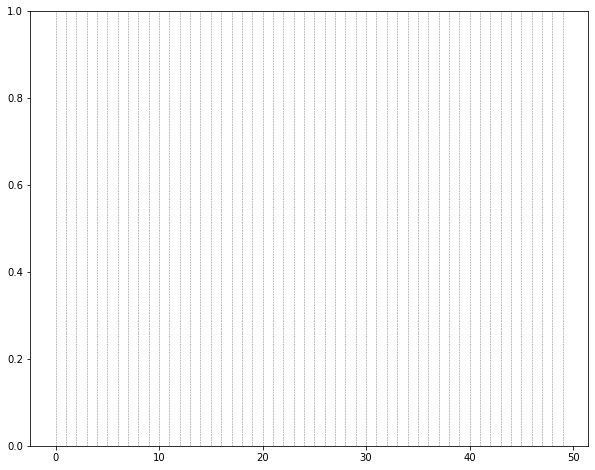

In [11]:
plt.figure(figsize=(10,8), facecolor="white")
from matplotlib import cm
from scipy.stats import halfnorm
for px in range(50): plt.axvline(px, linestyle="--", lw=0.5, alpha=0.5, color="k")
exptimes = np.unique(data['exptime'])
colors = cm.plasma(np.linspace(0, 1, len(exptimes)))
bins = np.linspace(0, 50, 200)

import galsim
i = 0
fluxes = []
sigmas = []
peakSignals = []
for exposure in data.group_by('exptime').groups:
    fluxes_temp = []
    sigmas_temp = []
    peakSignals_temp = []
    counter = 0

    for image in exposure:
        counter = counter+1
        if counter > 20:
            continue
        print(np.flatten(image['signals'][0])
        print("")
        array = image['signals'].reshape((66,66))
        img = galsim.Image(array)
        mom = img.FindAdaptiveMom(weight=None, strict=False)
        fluxes_temp.append(mom.moments_amp)
        sigmas_temp.append(mom.moments_sigma)
        peakSignals_temp.append(np.max(array))
    #print(len(fluxes_temp))
    fluxes.append(fluxes_temp)
    sigmas.append(sigmas_temp)
    peakSignals.append(peakSignals_temp)



In [5]:
import functools
import operator
plt.figure(figsize=(10,8), facecolor="white")
from matplotlib import cm
from scipy.stats import halfnorm
#for px in range(50): plt.axvline(px, linestyle="--", lw=0.5, alpha=0.5, color="k")
exptimes = np.unique(data['exptime'])
colors = cm.plasma(np.linspace(0, 1, len(exptimes)))
bins = np.linspace(0, 50, 200)

i = 0
radii_flattened = []
signals_flattened = []
for exposure in data.group_by('exptime').groups:
    exptime = np.mean(exposure['exptime'])
    print(exptime)
    
    #radii = functools.reduce(operator.iconcat, exposure['radii'], [])
    #signals = functools.reduce(operator.iconcat, exposure['signals'], [])
    radii = []
    signals = []
    for r,s in zip(exposure['radii'], exposure['signals']):
        #radii.extend(functools.reduce(operator.iconcat, exposure['radii'], []))
        #signals.extend(functools.reduce(operator.iconcat, exposure['signals'], []))
        for element in r:
            radii.extend(element.flatten().tolist())
        for element in s:
            signals.extend(element.flatten().tolist())
        
    radii_flattened.append(np.asarray(radii))
    signals_flattened.append(np.asarray(signals))

    #y = []
    #for j in range(len(bins)-1):
    #    cond = (radii>=bins[j]) & (radii<bins[j+1])
    #    selected_intensities = signals[cond]
        
    #    if selected_intensities.size==0:
    #        if j==0:
    #            y.append(np.nan)
    #        else:
    #            y.append(y[j-1])
    #    else:
    #        if selected_intensities.mean() == 0:
    #            y.append(y[j-1])
    #        else:
    #            y.append(selected_intensities.mean())
  

    #plt.plot(bins[0:-1], y, c=colors[i])
    #print(str(exptimes[i])+"s|"+ str(np.mean(y[40:45])) + "|" + str(np.max(y)) +"|" + str(np.sum(y)))
    #print(str(np.mean(y[40:45])) + ", ", end='')
    #if exptime==10.0:
    #    #print(len(exposure))
    #    for b in y:
    #        print(str(b) + ", ",end='')
    #    from lmfit.models import GaussianModel
    #    model = GaussianModel()
    #    params = model.make_params(amplitude=29000, sigma=1, center=0.)
    #    params['center'].vary = False  # fix the centroid at -1
    #    result = model.fit(y, params, x=bins[0:-1])
    #    #print(result.fit_report())
    #    xplot = np.linspace(0, 50, 101)
    #    yplot = result.eval(x=xplot)
    #    #plt.plot(xplot,yplot,"r--")

    #plt.title('SPOT #1200', fontsize=15)
    #plt.xlim(0,45)
    #plt.xticks([0,5,10,15,20,25,30,35,40,45], fontsize=15)

    #plt.yticks(fontsize=15)
    #plt.xlabel('$r - r_{centroid}$ [px]', fontsize=15)
    #plt.ylabel('$F$', fontsize=15)
    #plt.yscale('log')
    i = i+1

    


1.25
2.5
3.75
5.0
6.25
7.5
8.75
10.0
11.25
12.5
15.0
17.5
20.0
22.5
25.0
27.5
30.0
32.5
35.0
37.5
40.0
42.5
45.0
47.5
50.0


<Figure size 720x576 with 0 Axes>

In [6]:
with open('./R24_S11_uncorrected_r10-15_radii_flattened.pkl', 'wb') as f:
    pkl.dump(radii_flattened, f)
with open('./R24_S11_uncorrected_r10-15_signals_flattened.pkl', 'wb') as f:
    pkl.dump(signals_flattened, f)
with open('./R24_S11_uncorrected_exptimes.pkl', 'wb') as f:
    pkl.dump(exptimes, f)


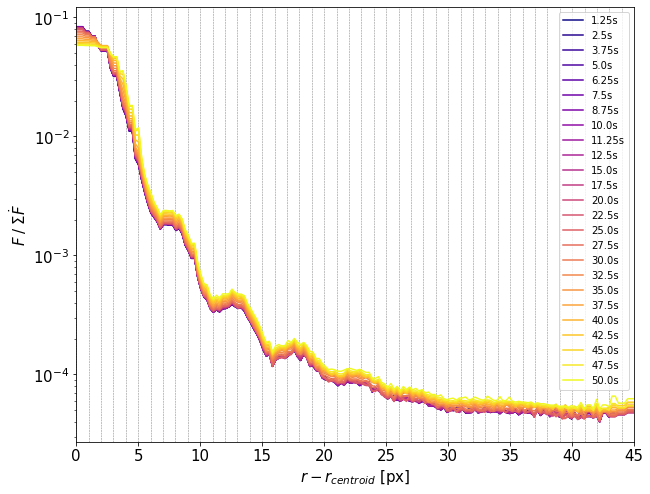

In [12]:
plt.figure(figsize=(10,8), facecolor="white")
for px in range(50): plt.axvline(px, linestyle="--", lw=0.5, alpha=0.5, color="k")
colors = cm.plasma(np.linspace(0, 1, len(exptimes)))
bins = np.linspace(0, 50, 200)

for i,exptime in enumerate(exptimes):
    y = []
    radii = radii_flattened[i]
    signals = signals_flattened[i]
    for j in range(len(bins)-1):
        cond = (radii>=bins[j]) & (radii<bins[j+1])
        selected_intensities = signals[cond]
        
        if selected_intensities.size==0:
            if j==0:
                y.append(np.nan)
            else:
                y.append(y[j-1])
        else:
            if selected_intensities.mean() == 0:
                y.append(y[j-1])
            else:
                y.append(selected_intensities.mean())
  

    plt.plot(bins[0:-1], y/np.nansum(y), c=colors[i], label=str(exptime) + 's')
    #if exptime==10.0:
    #    #print(len(exposure))
    #    for b in y:
    #        print(str(b) + ", ",end='')
    #    from lmfit.models import GaussianModel
    #    model = GaussianModel()
    #    params = model.make_params(amplitude=29000, sigma=1, center=0.)
    #    params['center'].vary = False  # fix the centroid at -1
    #    result = model.fit(y, params, x=bins[0:-1])
    #    #print(result.fit_report())
    #    xplot = np.linspace(0, 50, 101)
    #    yplot = result.eval(x=xplot)
    #    #plt.plot(xplot,yplot,"r--")

    #plt.title('SPOT #1200', fontsize=15)
    plt.xlim(0,45)
    plt.xticks([0,5,10,15,20,25,30,35,40,45], fontsize=15)

    plt.yticks(fontsize=15)
    plt.xlabel('$r - r_{centroid}$ [px]', fontsize=15)
    plt.ylabel('$F\;/\;\Sigma\.F$', fontsize=15)
    plt.yscale('log')
    
plt.legend()
plt.savefig("./plots/spotprofile.png", bbox_inches='tight')

In [13]:
plt.savefig("./plots/spotprofile.png", bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

IndexError: index 25 is out of bounds for axis 0 with size 25

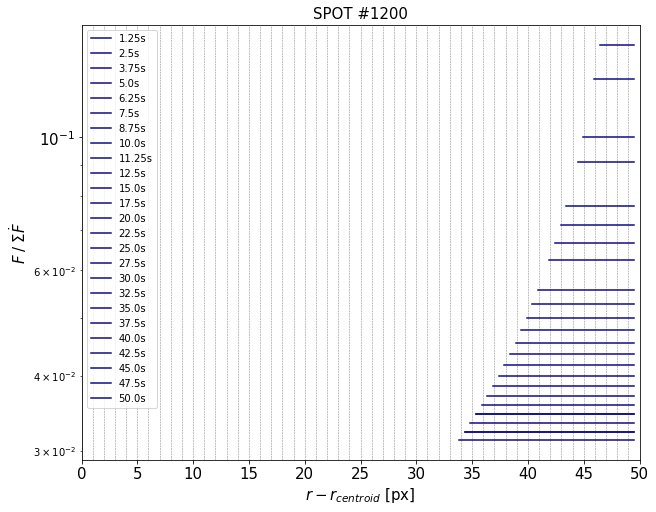

In [6]:
plt.figure(figsize=(10,8), facecolor="white")
from matplotlib import cm
for px in range(50): plt.axvline(px, linestyle="--", lw=0.5, alpha=0.5, color="k")
colors = cm.plasma(np.linspace(0, 1, len(signals)))

for i, each in enumerate(signals):
    each = np.asarray(each)
    bins = np.linspace(0, 50, 100)
    y = []
    for j in range(len(bins)-1):
        cond = (radii[i]>=bins[j]) & (radii[i]<bins[j+1])
        selected_intensities = each[cond]
        
        if selected_intensities.size==0:
            if j==0:
                y.append(np.nan)
            else:
                y.append(y[j-1])
        else:
            if selected_intensities.mean() == 0:
                y.append(y[j-1])
            else:
                y.append(selected_intensities.mean())

    plt.plot(bins[0:-1], y/np.nansum(y), c=colors[i], label=str(exptimes[i]) + 's')
    plt.title('SPOT #1200', fontsize=15)
    plt.xlim(0,50)
    plt.xticks([0,5,10,15,20,25,30,35,40,45,50], fontsize=15)

    plt.yticks(fontsize=15)
    plt.legend()
    plt.xlabel('$r - r_{centroid}$ [px]', fontsize=15)
    plt.ylabel('$F\;/\;\Sigma\.F$', fontsize=15)
    plt.yscale('log')


IndexError: index 25 is out of bounds for axis 0 with size 25

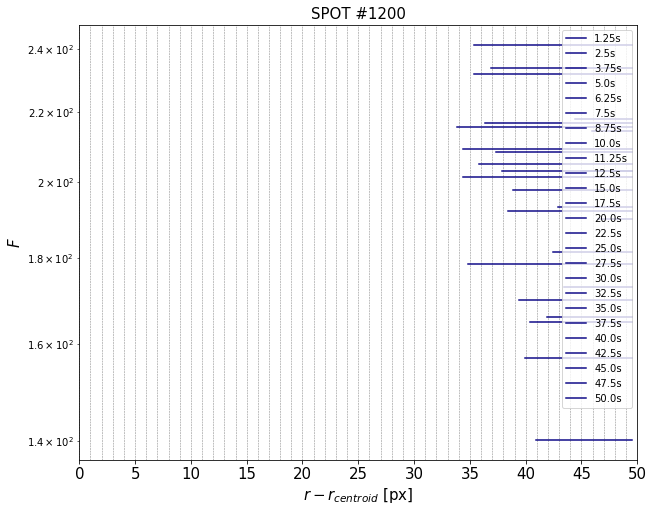

In [7]:
plt.figure(figsize=(10,8), facecolor="white")
from matplotlib import cm
for px in range(50): plt.axvline(px, linestyle="--", lw=0.5, alpha=0.5, color="k")
colors = cm.plasma(np.linspace(0, 1, len(signals)))

for i, each in enumerate(signals):
    each = np.asarray(each)
    bins = np.linspace(0, 50, 100)
    y = []
    for j in range(len(bins)-1):
        cond = (radii[i]>=bins[j]) & (radii[i]<bins[j+1])
        selected_intensities = each[cond]
        
        if selected_intensities.size==0:
            if j==0:
                y.append(np.nan)
            else:
                y.append(y[j-1])
        else:
            if selected_intensities.mean() == 0:
                y.append(y[j-1])
            else:
                y.append(selected_intensities.mean())

    plt.plot(bins[0:-1], y, c=colors[i], label=str(exptimes[i]) + 's')
    plt.title('SPOT #1200', fontsize=15)
    plt.xlim(0,50)
    plt.xticks([0,5,10,15,20,25,30,35,40,45,50], fontsize=15)

    plt.yticks(fontsize=15)
    plt.legend(loc=1)
    plt.xlabel('$r - r_{centroid}$ [px]', fontsize=15)
    plt.ylabel('$F$', fontsize=15)
    plt.yscale('log')


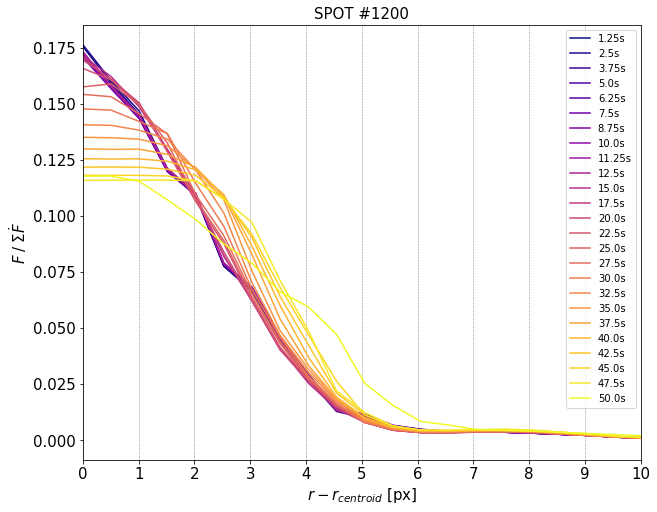

In [8]:
plt.figure(figsize=(10,8), facecolor="white")
from matplotlib import cm
for px in range(10): plt.axvline(px, linestyle="--", lw=0.5, alpha=0.5, color="k")
colors = cm.plasma(np.linspace(0, 1, len(signals)))



for i, each in enumerate(signals):
    each = np.asarray(each)
    bins = np.linspace(0, 50, 100)
    y = []
    for j in range(len(bins)-1):
        cond = (radii[i]>=bins[j]) & (radii[i]<bins[j+1])
        selected_intensities = each[cond]
        
        if selected_intensities.size==0:
            if j==0:
                y.append(np.nan)
            else:
                y.append(y[j-1])
        else:
            if selected_intensities.mean() == 0:
                y.append(y[j-1])
            else:
                y.append(selected_intensities.mean())

    plt.plot(bins[0:-1], y/np.nansum(y), c=colors[i], label=str(exptimes[i]) + 's')
    plt.title('SPOT #1200', fontsize=15)
    plt.xlim(0,10)
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10], fontsize=15)

    plt.yticks(fontsize=15)
    plt.legend()
    plt.xlabel('$r - r_{centroid}$ [px]', fontsize=15)
    plt.ylabel('$F\;/\;\Sigma\.F$', fontsize=15)
    #plt.yscale('log')


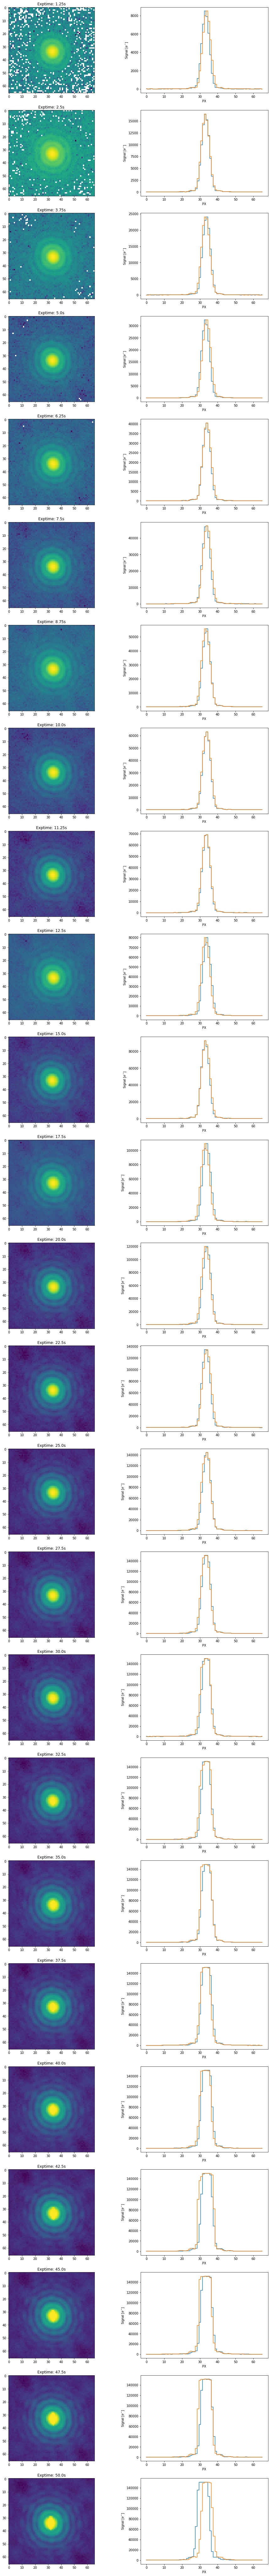

In [9]:
from matplotlib.colors import LogNorm

exptimes = np.unique(data['exptime'])
prevax = 0
plt.figure(figsize=(8*2, 6*len(exptimes)))
for i, exptime in enumerate(sorted(exptimes)):
    ax = plt.subplot(len(exptimes), 2, 2*(i+1)-1)
    cond = np.argwhere(data['exptime'] == exptime)
    calib_spot = np.mean(data['image'][cond][0], axis=0)
    ax.set_title("Exptime: " + str(exptime) + "s")
    ax.imshow(calib_spot, norm=LogNorm())
    
    ax2 = plt.subplot(len(exptimes), 2, 2*(i+1))
    ind = np.argwhere(calib_spot == np.max(calib_spot))
    x,y = ind[0][0], ind[0][1]
    ax2.plot(calib_spot[x,:], drawstyle='steps-mid')
    ax2.plot(calib_spot[:,y], drawstyle='steps-mid')
    ax2.set_xlabel("PX")
    ax2.set_ylabel('Signal [$e^{-}$]')
    
    

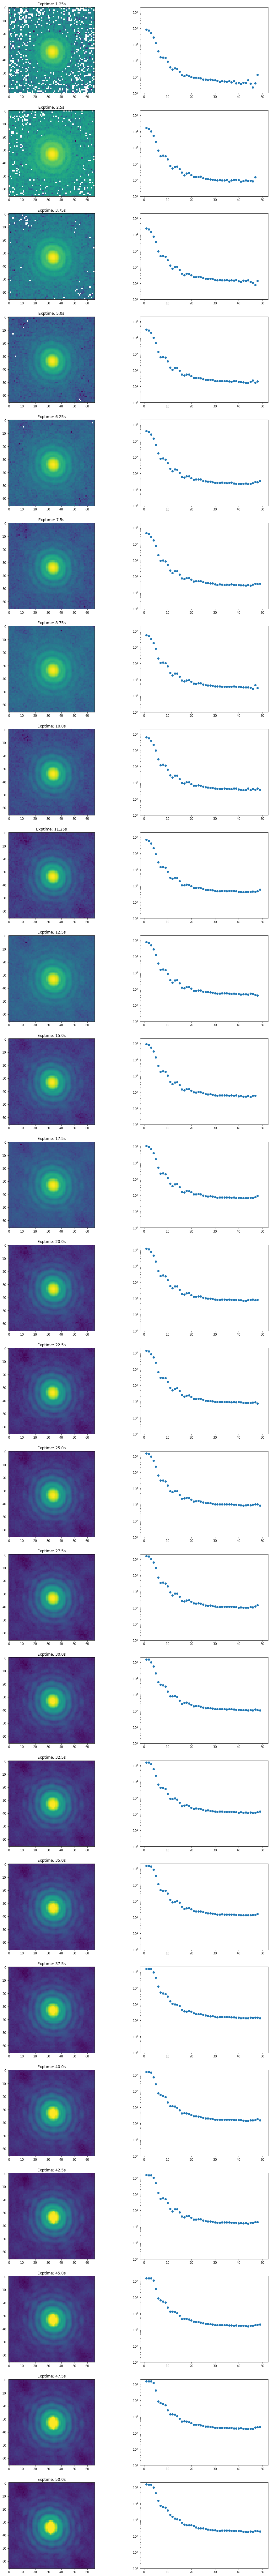

In [10]:
exptimes = np.unique(data['exptime'])
prevax = 0
plt.figure(figsize=(8*2, 6*len(exptimes)))
radii = []
signals = []
for i, exptime in enumerate(sorted(exptimes)):
    ax = plt.subplot(len(exptimes), 2, 2*(i+1)-1)
    cond = np.argwhere(data['exptime'] == exptime)
    calib_spot = np.mean(data[cond]['image'][0], axis=0)
    ax.set_title("Exptime: " + str(exptime) + "s")
    ax.imshow(calib_spot, norm=LogNorm())
    
    center = np.argwhere(calib_spot == np.max(calib_spot))
    x0, y0 = center[0][0], center[0][1]
    
    
    r = []
    signal= []
    distmatrix = np.zeros(calib_spot.shape)
    for i_tmp in range(calib_spot.shape[0]):
        for j_tmp in range(calib_spot.shape[1]):
            distmatrix[i_tmp][j_tmp] = np.sqrt( (i_tmp-x0)**2+ (j_tmp-y0)**2)

    signal = []
    for r in np.linspace(1,50,50):
        N = len(calib_spot[np.argwhere((distmatrix < r) & (distmatrix >= r-1))])
        if N==0:
            signal.append(0.)
        else:
            vals = calib_spot[ np.where((distmatrix < r) & (distmatrix >= r-1)) ]
            signal.append(np.median(vals))

    ax2 = plt.subplot(len(exptimes), 2, 2*(i+1))
    radii.append(np.linspace(1,50,50))
    signals.append(signal)
    ax2.scatter(np.linspace(1,50,50), signal)
    ax2.set_ylim(1,2e5)
    ax2.set_yscale('log')
    
 

Text(0.5, 0, 'r [px]')

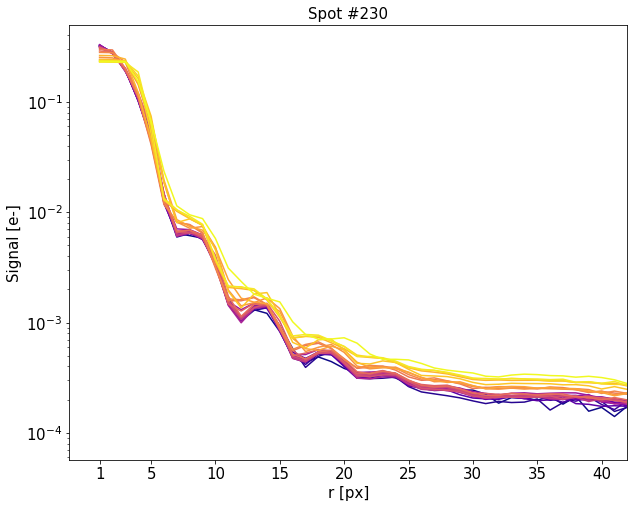

In [11]:
plt.figure(figsize=(10,8))
import matplotlib
from matplotlib import cm

colors = cm.plasma(np.linspace(0, 1, len(exptimes)))

from scipy.ndimage import gaussian_filter
        
for i, row in enumerate(signals):
    row = np.asarray(row)
    radii = np.asarray(radii)
    cond = (row > 0.)
    plt.plot(radii[i][cond],row[cond] / np.sum(row[cond]), c=colors[i])
    plt.xticks([1,5,10,15,20,25,30,35,40], fontsize=15)
    plt.xlim(xmax=42)
    plt.yticks(fontsize=15)
    plt.yscale('log')

plt.title("Spot #230", fontsize=15)
plt.ylabel("Signal [e-]", fontsize=15)
plt.xlabel("r [px]", fontsize=15)